# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection

In [3]:
con = mysql.connector.connect( user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees' )

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor = con.cursor()

In [5]:
min_max_hire_date = """
SELECT MAX(hire_date), MIN(hire_date) 
FROM employees
"""
cursor.execute( min_max_hire_date )
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [6]:
import pandas as pd

In [7]:
latest_salaries = """
SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
JOIN (
    SELECT emp_no, MAX(from_date) max_from_date, MAX(to_date) max_to_date
    FROM salaries
    GROUP BY emp_no
) ls ON s.emp_no = ls.emp_no AND s.from_date = ls.max_from_date AND s.to_date = ls.max_to_date
"""

cursor.execute( latest_salaries )

result = cursor.fetchall()
field_names = [i[0] for i in cursor.description]

res = pd.DataFrame( result, columns = field_names )
display( res.columns, res.shape, res.head(3) )


Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

(300024, 4)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


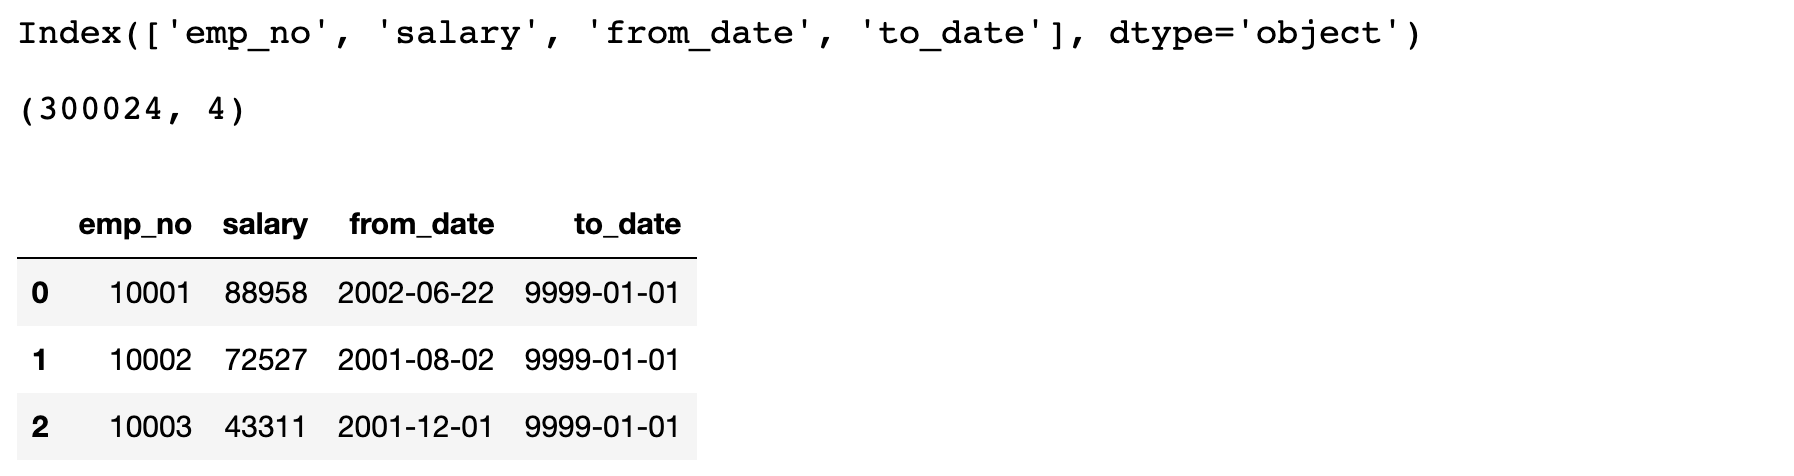

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [8]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

In [9]:
res.isna().sum()

emp_no       0
salary       0
from_date    0
to_date      0
dtype: int64

In [10]:
res['to_date'] = res['to_date'].astype(str)


In [11]:
res['to_date'] = res['to_date'].str.strip()

In [12]:
current_employees_count = ( res['to_date'] == '9999-01-01' ).sum()
former_employees_count = ( res['to_date'] != '9999-01-01' ).sum()
display( current_employees_count, former_employees_count )

240124

59900

6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

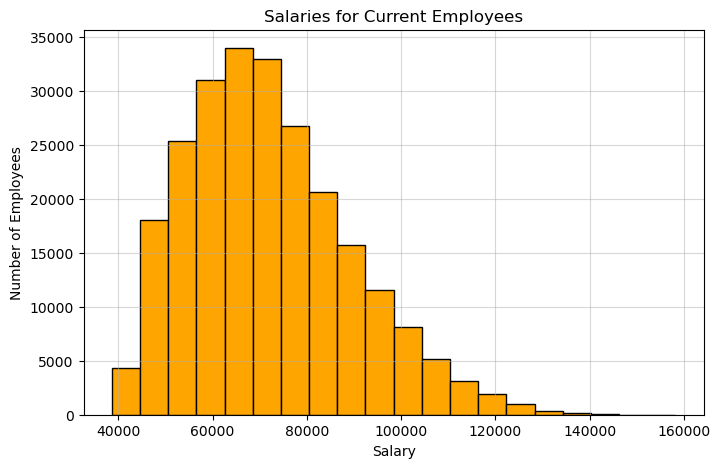

In [13]:
import matplotlib.pyplot as plt

current_employees = res[ res['to_date'] == '9999-01-01' ]

plt.figure( figsize = (8, 5) )
plt.hist( current_employees['salary'], bins = 20, color = 'orange', edgecolor = 'black' )
plt.title( 'Salaries for Current Employees' )
plt.xlabel( 'Salary' )
plt.ylabel( 'Number of Employees' )
plt.grid( axis = 'both', alpha = 0.5 )

plt.show()

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [14]:
from pandasql import sqldf

In [15]:
import warnings

warnings.filterwarnings( 'ignore' )

In [16]:
emp_hired_per_year = """
SELECT YEAR(hire_date) hire_year, COUNT(emp_no) emp_num 
FROM employees 
GROUP BY YEAR(hire_date) 
ORDER BY YEAR(hire_date)
"""

df = pd.read_sql( emp_hired_per_year, con )

display(df)

,hire_year,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


Очікуваний результат:

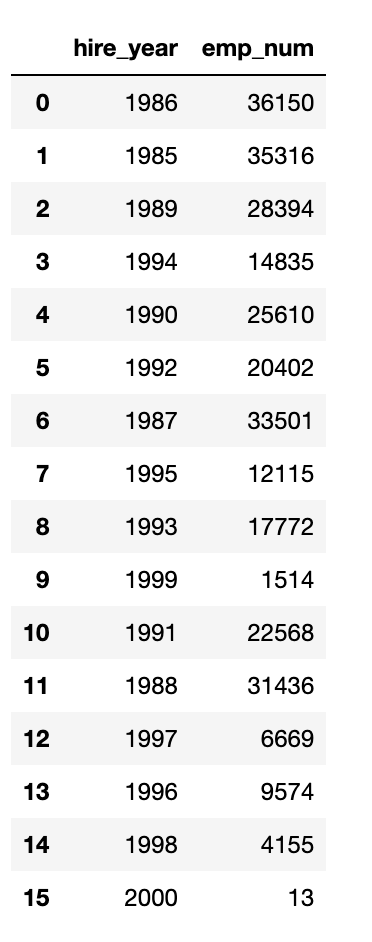

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

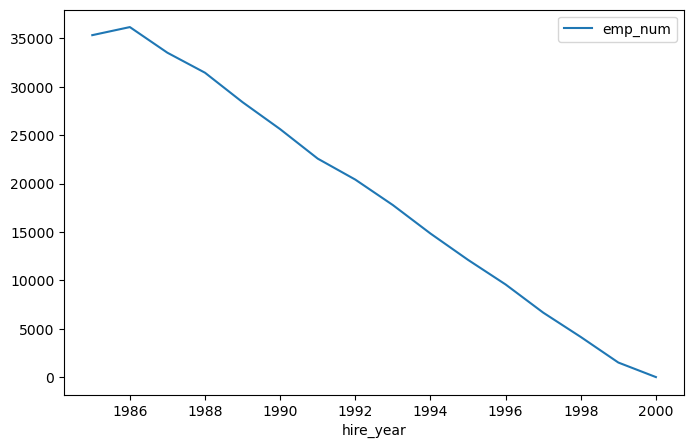

In [17]:
plt.figure( figsize = ( 8, 5 ) )

plt.plot( df['hire_year'], df['emp_num'], label='emp_num' )

plt.xlabel( 'hire_year' )
plt.legend()
plt.show();

Очікуваний результат:

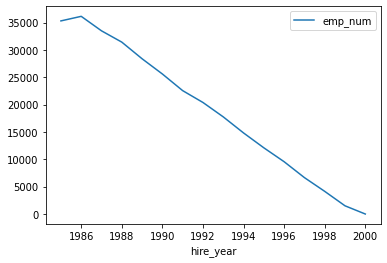

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [18]:
former_engineers = """
SELECT TIMESTAMPDIFF(YEAR, from_date, to_date) duration, from_date, to_date
FROM titles
WHERE title = 'Engineer' AND to_date != '9999-01-01'
"""
df_years = pd.read_sql( former_engineers, con )
display(df_years)

,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


Очікуваний результат:

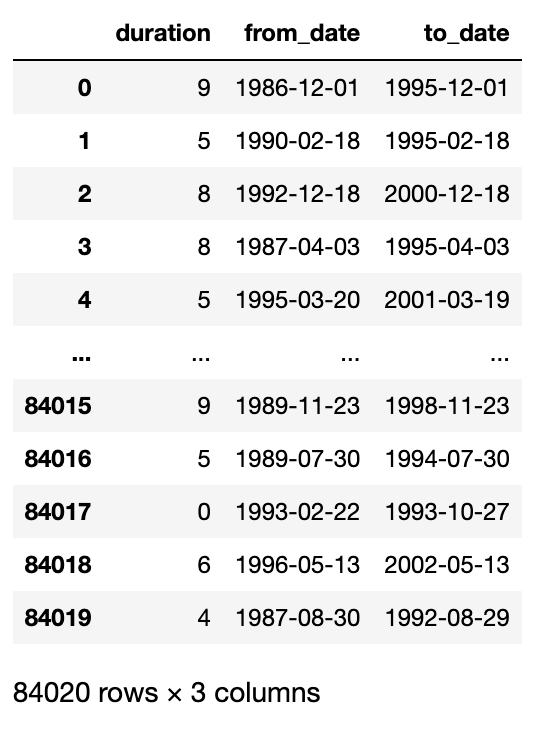

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

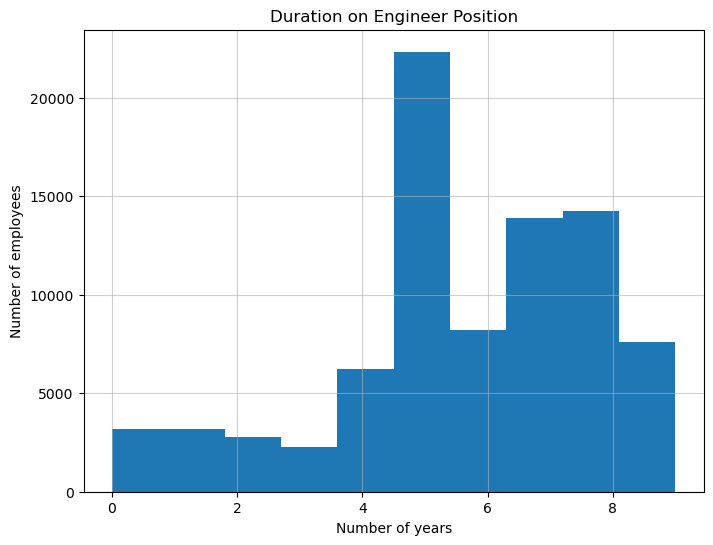

In [19]:
plt.figure(figsize = (8, 6) )

plt.hist( df_years['duration'] )
plt.title( 'Duration on Engineer Position' )
plt.xlabel( 'Number of years' )
plt.ylabel( 'Number of employees' )
plt.grid( axis = 'both', alpha = 0.6 )
plt.show()

Очікуваний результат:

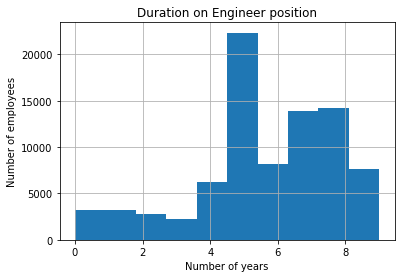

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [20]:
con.close()